<hr style="height:2px;border:none"/>
<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

INF-395 / 477 / 577 Tarea 2 Redes Neuronales Artificiales - 2020-2 </h1>

<H3 align='center'> Integrantes: Paula Nieto - Gabriela Sepúlveda </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones en tensorflow, keras, pandas y numpy
* Recurrent Neural Networks
* LSTM, GRU
* Autoencoders
* GAN

**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno para toda la tarea, con tal de que todos los entregables estén bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_ ( en caso de ser repositorio privado, invitar como colaborador al usuario de github "Aerlio") al correo electrónico del ayudante (*<tomas.ochoa.14@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF395/477/577-2020 Tarea 2]
* Fecha de entrega y presentaciones: 8 de Enero. Hora límite de entrega: 23:00. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en tres partes:

[1.](#primero) RNNs para series de tiempo  <br>
[2.](#segundo) RNNs para texto <br>
[3.](#tercero) Autoencoders para imágenes <br>
[3.](#cuarto) GANs para imágenes <br>

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guías y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier analisis, fórmula o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.

**Es ÁLTAMENTE recomendado realizar esta tarea en _Colab_ de Google (https://colab.research.google.com/notebooks/intro.ipynb#recent=true), con el fin de no depender del rendimiento de su computador personal al momento de entrenar redes neuronales y poder compartir de forma fácil sus avances con su compañer@ de trabajo.** Si bien conlleva sus pros y contras utilizar _Colab_ , existirá una curva de aprendizaje personal que lo ayudará a sacar el mayor provecho a esta herramienta, por ejemplo aprendiendo a guardar los avances realizados, evitando tener que ejecutar todo el código cada vez que se abra _Colab_ . *Tip: Una vez abierto un notebook en _Colab_ ir a **entorno de ejecución**->**Cambiar tipo de entorno de ejecución**, y seleccionár TPU como acelerador por hardware para redes recurrentes y GPU para redes convolucionales.*.

# 2. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />

## 2.a Carga de datos y preprocesamientos


In [51]:
username="gabrielasepulveda"
key="c4e7170af8d4e1a4413214439170379f"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
if not os.path.exists("/content/NER"):
    os.makedirs("/content/NER")
os.chdir('/content/NER')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

entity-annotated-corpus.zip: Skipping, found more recently modified local copy (use --force to force download)
entity-annotated-corpus.zip  ner.csv  ner_dataset.csv


##### I) Investigue en la documentación del dataset cual es la tarea original para el cual fue propuesto, en particular cuál es la variable que buscamos predecir, a qué se refiere esta misma y por qué es necesario utilizar técnicas avanzadas para resolver esta tarea (¿no bastaría con un diccionario?).

**Respuesta**
Este extracto del GMB (Groningen Meaning Bank, el cual comprende miles de textos, etiquetas de discuso, entidades con nombre y categorías léxicas), está construido específicamente para entrenar al 'clasificador' a predecir entidades con nombre, ubicación, evento, etc; que es lo que se conoce como NER (Named-entity recognition). Lo que buscamos es detectar nombres y ser capaces de clasificar estos nombres según la entidad a la que hacen referencia.

Es necesario utilizar técnicas avanzadas para abordar esta problemática porque un diccionario no es capaz de reconocer nombres según la entidad a la que está relacionada. Por ejemplo, la palabra "Ford" podría hacer referencia a muchas entidades distintas como se puede apreciar en la siguiente oración: *La compañía automotriz creada por Henry Ford en 1903 está relacionada con los designadores Ford o Ford Motor Company*. Un diccionario no podría ser capaz de distinguir cuál "Ford" hace referencia a la persona y cuál hace referencia a la marca.

---

Cargue el conjunto de datos. Este conjunto de datos es bastante grande, por lo que como ven en el código propuesto, nos contentaremos con no considerar las lineas corruptas del registro.

En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?**

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
data = df_ner.loc[:,['lemma','tag','word','sentence_idx']]
data_original = df_ner.loc[:,['lemma','tag','word','sentence_idx']]

# Mostrar primeros 20 elementos
data[0:20]

b'Skipping line 281837: expected 25 fields, saw 34\n'


,lemma,tag,word,sentence_idx
0,thousand,O,Thousands,1.0
1,of,O,of,1.0
2,demonstr,O,demonstrators,1.0
3,have,O,have,1.0
4,march,O,marched,1.0
5,through,O,through,1.0
6,london,B-geo,London,1.0
7,to,O,to,1.0
8,protest,O,protest,1.0
9,the,O,the,1.0


**Respuesta**

Nos conviene utilizar *lemma* en vez de la palabra misma, porque el tener esta representación "canónica" de la palabra nos permitirá identificar todo el conjunto canónico de palabras que involucren un concepto dado.

**Extra**

Para no perder ciertos datos a la hora de graficar y visualizar la data, se utilizará la siguiente función que agrupa las sentencias en un diccionario.

In [53]:
# get from https://www.kaggle.com/ritvik1909/rnn-named-entity-recognition
class SentenceGetter(object):
    
    def __init__(self, dataset, lemma_col, tag_col, sent_id_col):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [
            (w, t) for w,t in zip(s[lemma_col].values.tolist(), s[tag_col].values.tolist())
        ]
        self.grouped = self.dataset.groupby(sent_id_col).apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

##### II) Para poder utilizar este conjunto de datos, debemos transformar nuestra tabla de palabras y sentencias, a una tabla donde cada entrada sea una sentencia, ademas codificando los distintos lemmas y tags como valores numéricos. Esto pueden realizarlo con alguna de las utilidades de keras o sklearn, sin embargo en el código siguiente se propone un metodo solo usando python y pandas. Pueden utilizar el método que deseen. Note eso si que independiente la aproximación que utilice debe comenzar desde 1 para la codificación, pues el valor 0 lo reservaremos para representar la ausencia de palabras más adelante.

**Explique qué realiza cada linea del código.**

In [54]:
import numpy as np

# Transforma el lemma a un valor numérico
lemma_to_code = {lemma:code+1 for code, lemma in enumerate(data.lemma.unique())}

# Tranforma el tag a un valor numérico
tag_to_code = {tag:code+1 for code, tag in enumerate(data.tag.unique())}

# Determina la cantidad de lemmas
n_lemmas = len(lemma_to_code)
n_tags = len(tag_to_code)

# Reemplaza en el dataset los lemma por su valor numérico
data['lemma'] = data.lemma.apply(lambda x: lemma_to_code[x])

# Reemplaza en el dataser los tag por su valor numérico
data['tag'] = data.tag.apply(lambda x: tag_to_code[x])

# Genera un nuevo dataset, agrupado por sentencia y 
# en donde cada una de ellas tiene los lemmas y tags asociados (en valor numérico)
dff = data.groupby("sentence_idx")[['lemma','tag']].agg(list).applymap(np.asarray)

In [55]:
# Creación del diccionario
getter = SentenceGetter(dataset=data_original, lemma_col='lemma', tag_col='tag', sent_id_col='sentence_idx')
sentences = getter.sentences #Agrupa por sentencias, el lemma con su tag

In [56]:
# Creación del diccionario con valor numérico
getter_code = SentenceGetter(dataset=data, lemma_col='lemma', tag_col='tag', sent_id_col='sentence_idx')
sentences_code = getter_code.sentences #Agrupa por sentencias, el codde del lemma con el code de su tag

## 2.b) Distribuciones.

Ahora que ya tenemos las sentencias codificadas y agrupadas, explore el tamaño de estas, en número de lemmas: ¿Son todas las sentencias de igual tamaño? ¿Le hace sentido esto? ¿Las redes que conoce pueden manajar ejemplos de distintos tamaños, y si pueden qué problemas podría traer? ¿Están las clases repartidas de manera equitativa?

Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?** (https://es.wikipedia.org/wiki/Ley_de_Zipf). Realice un gráfico de la cantidad de datos por clase. Comente.

Numero de sentencias: 35177
Secuencia mas larga: 140


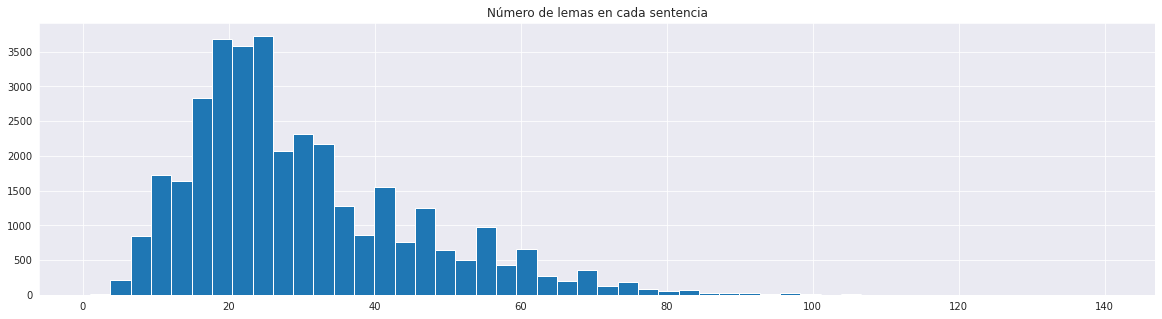

In [57]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.hist([len(s) for s in sentences], bins=50)
ax.set_title('Número de lemas en cada sentencia')

maxlen = max([len(s) for s in sentences])
print('Numero de sentencias:', len(sentences))
print ('Secuencia mas larga:', maxlen)

lemmas = list(set(data["lemma"].values))
lemmas.append("ENDPAD")
n_lemmas = len(lemmas)

Text(0.5, 1.0, 'Boxplot')

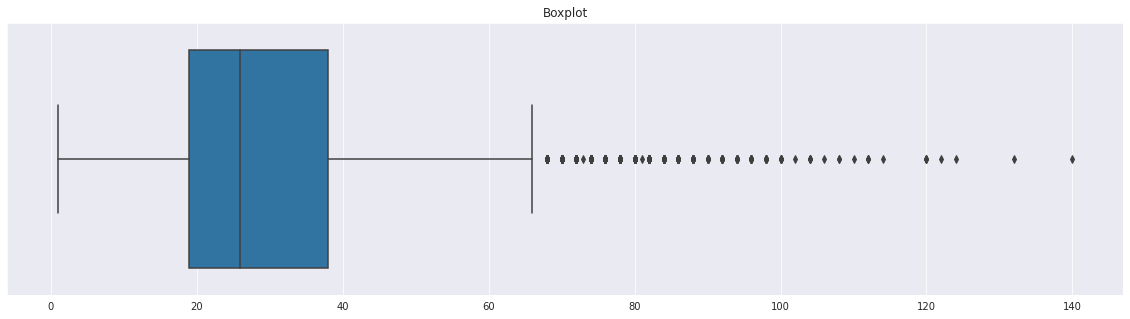

In [58]:
plt.rcParams['figure.figsize']=[20,5]
sns.boxplot( x=[len(s) for s in sentences]).set_title("Boxplot")

vemos claramente como la distribución de la cantidad de palabras por sentencia tiene una distribución sesgada hacia la izquierdam concentra sus valores entre 18 y 38 aproximadamente.

Text(0.5, 1.0, 'Número de lemas en cada sentencia')

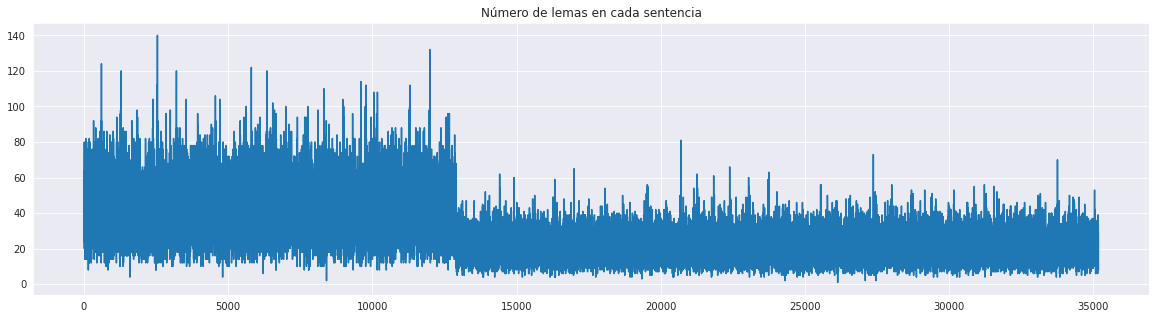

In [60]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([len(s) for s in sentences])
ax.set_title('Número de lemas en cada sentencia')

Como es muy dispersa la cantidad de lemas por cada sentencia, se graficarán las primeras 100 sentencias para observar de mejor manera su comportamiento.

Text(0.5, 1.0, 'Número de lemas en cada sentencia')

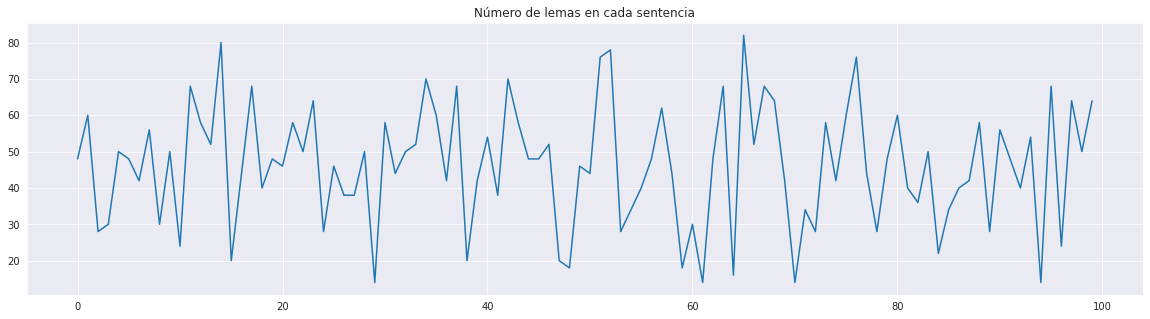

In [61]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([len(s) for s in sentences[0:100]])
ax.set_title('Número de lemas en cada sentencia')

Como podemos ver la cantidad de lemas por cada sentencia es muy dispersa entre cada una y la otra.. Además, veremos de que manera están distribuidos los tags.

Cantidad de tags: 17


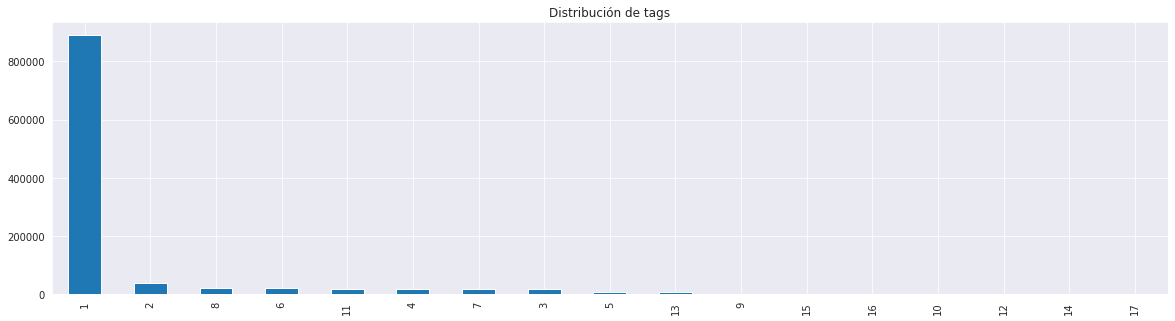

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
data.tag.value_counts().plot.bar(ax=ax, title='Distribución de tags')

tags = list(set(data_original["tag"].values))
n_tags = len(tags)
print('Cantidad de tags:', n_tags)

**Respuesta**

Las sentencias no son de igual tamaño, lo que tiene todo el sentido ya que muchas veces utilizamos sentencias cortas para comunicar algo, versus otras veces que utilizamos sentencias largas.

Las RNN permiten variar el tamaño de las entradas, ya que lo que se hace es establecer relaciones entre los elementos de una secuencia; y es que se pueden enmascarar las secuencias mas cortas con 0's (Es necesario ya que todas las entradas de los modelos Keras deben ser tensores).


## 2.c) Padding y one hot vectors

##### I) En esta parte de la tarea, deben lograr que todas las secuencias de lemmas (y los tags correspondientes) queden del mismo largo, es decir realizar padding. El padding debe realizarse con el valor 0, pueden escoger si realizarlo al comienzo de la secuencia o al final, expliquen su elección. Pueden utilizar la función keras.preprocessing.sequence.pad_sequences o escribir sus propios códigos. Elija un valor de maxlen que le parezca adecuado.

¿Opinan que es deseable utilizar el valor 0 como codificación de palabras que "no existen", o creen que es irrelevante por ejemplo que su valor sea 1?

In [63]:
lemmas = list(set(data_original["lemma"].values))
lemma_to_code2 = {w: i for i, w in enumerate(lemmas)}
tags = list(set(data_original["tag"].values))
tag_to_code2 = {t: i for i, t in enumerate(tags)}

In [64]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [65]:
# Lemma
X1 = pad_sequences(dff.lemma, maxlen=maxlen, padding='post', value=0).tolist()

In [66]:
# Tag
y1 = pad_sequences(dff.tag, maxlen=maxlen, padding='post', value=0).tolist()

**Comentarios**

Vamos a verificar que efectivamente se haya realizado el padding graficando la distribución de las palabras.

Text(0.5, 1.0, 'Numero de lemas en cada sentencia')

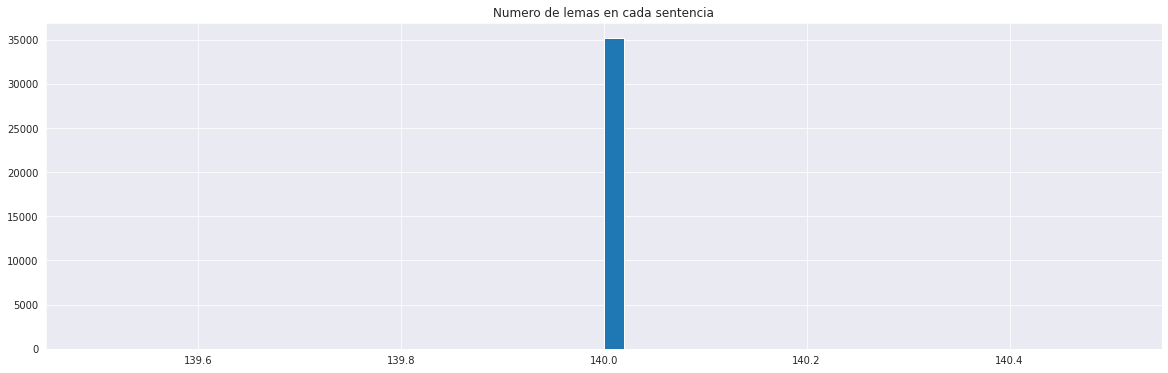

In [67]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(X1[i]) for i in range(len(X1))], bins=50)
ax.set_title('Numero de lemas en cada sentencia')

Text(0.5, 1.0, 'Numero de tags en cada sentencia')

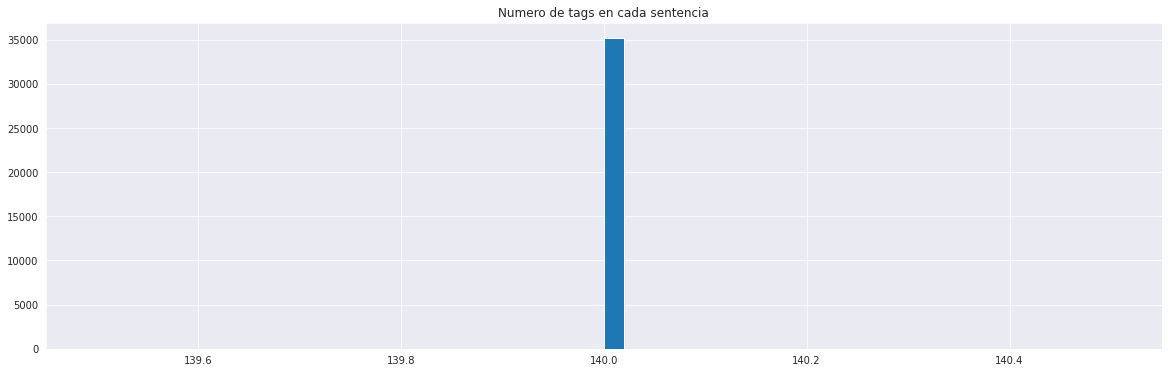

In [68]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(y1[i]) for i in range(len(y1))], bins=50)
ax.set_title('Numero de tags en cada sentencia')

**Respuesta**

No podemos asignarle el valor de 1 a las palabras no existentes, puesto que este numero ya está asignado a un lemma en específico. Además, se ha optado por realizar un padding en el final de la secuencia, ya que teóricamente no debería cambiar la precisión del modelo.

**Comentarios**

En el gráfico se puede observar como tantos los lemmas, como los tag quedaron con 140 valores, que corresponde a la secuencia más larga encontrada en el dataframe.

II) Para poder entregar una clasificación sobre los distintos tags es necesario transformarlos a one hot vectors, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles tags. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación ¿Cuáles son las dimensiones de entrada y salida de cada conjunto? Comente

In [69]:
y = np.asarray([to_categorical(i, num_classes=n_tags+1) for i in y1])
y

array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [71]:
x_tr, x_val, y_tr, y_val = train_test_split(X1, y, test_size=0.25, random_state=1)

In [72]:
x_tr = np.asarray(x_tr)
x_val = np.asarray(x_val)
y_tr = np.asarray(y_tr)
y_val = np.asarray(y_val)

In [76]:
x_tr.shape,y_tr.shape,x_val.shape,y_val.shape

((26382, 140), (26382, 140, 18), (8795, 140), (8795, 140, 18))

In [75]:
total = x_tr.shape[0] + x_val.shape[0]
training = ( 100 / total ) * x_tr.shape[0]
test = ( 100 / total ) * x_val.shape[0]

print('- Train Set: '+str(training)+"%%")
print('- Val Set: '+str(test)+"%%")

- Train Set: 74.99786792506467%%
- Val Set: 25.002132074935325%%


**Comentarios**

- x_tr : Tiene un tamaño de una cantidad de sentencias (75%) x el largo máximo de éstas
- y_tr: Tiene un tamalo de una cantidad de sentencias (25%) x el largo máximo de éstas x la cantidad de tags
- x_val: Tiene un tamaño de una cantidad de sentencias (75%) x el largo máximo de éstas
- y_val: Tiene un tamaño de una cantidad de sentencias (25) x el largo mázimo de éstas x la cantidad de tags

## 2.d) RNN many to many


##### I) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.

In [78]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

#¿problemas con el embedding al ejecutar? chequear que el n_lemas, n_tags, y max_len correspondan a los datos modificados con padding
m = Sequential()
embedding_dim = 32

m.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=maxlen))
m.add(LSTM(units=128,return_sequences=True))
m.add(Dense(n_tags+1, activation='softmax'))
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 92s 434ms/step - loss: 0.9401 - acc: 0.8341 - val_loss: 0.2018 - val_acc: 0.9649
Epoch 2/3
207/207 [==============================] - 92s 442ms/step - loss: 0.1875 - acc: 0.9662 - val_loss: 0.1418 - val_acc: 0.9675
Epoch 3/3
207/207 [==============================] - 92s 444ms/step - loss: 0.1274 - acc: 0.9675 - val_loss: 0.0921 - val_acc: 0.9738


In [79]:
m.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 140, 32)           647840    
_________________________________________________________________
lstm_8 (LSTM)                (None, 140, 128)          82432     
_________________________________________________________________
dense_7 (Dense)              (None, 140, 18)           2322      
Total params: 732,594
Trainable params: 732,594
Non-trainable params: 0
_________________________________________________________________


**Comentarios**

Tenemos un total de 732.594 parámetros, todos entrenables. Además podemos ver que la dimensión de salida se va reduciendo hasta llegar a los 18 tags (Los 17 más el '0').



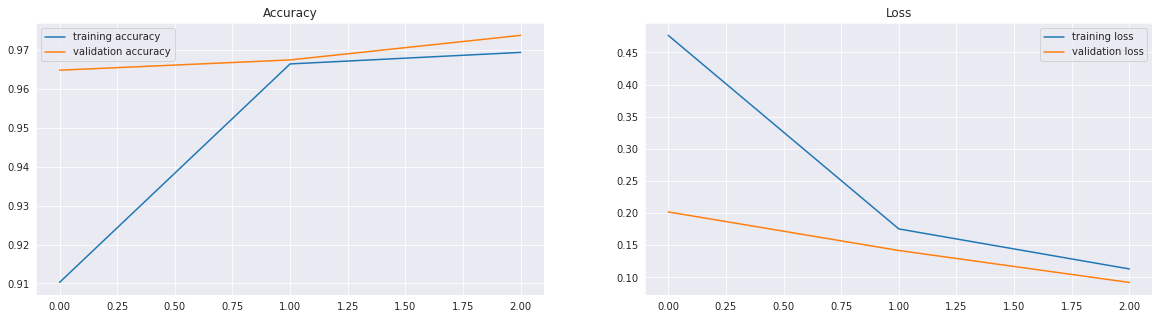

In [80]:
#Gráficos 
fig, ax = plt.subplots(figsize=(20, 5))

plt.subplot(1,2,1)
plt.title("Accuracy")
plt.plot(history.history["acc"],label="training accuracy")
plt.plot(history.history["val_acc"],label="validation accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.title("Loss")
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.legend()

plt.show()

Para evaluar su modelo utilice una métrica adecauda para el desbalance presente entre las clases.

In [81]:
!pip install sklearn_crfsuite

In [82]:
from sklearn_crfsuite.metrics import flat_classification_report 

In [83]:
y_pred = m.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
y = np.argmax(y_val, axis=1)

In [84]:
report = flat_classification_report(y,y_pred,labels=[0]+list(tag_to_code.values()), digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9913    0.4977    0.6627    128682
           1     0.0318    0.0998    0.0483      3738
           2     0.0600    0.1116    0.0780      1881
           3     0.0963    0.2491    0.1389      1172
           4     0.1287    0.3261    0.1845      1282
           5     0.1275    0.4035    0.1938      1088
           6     0.1295    0.4427    0.2004      1039
           7     0.1359    0.4500    0.2087      1051
           8     0.1365    0.4487    0.2094       965
           9     0.1266    0.4022    0.1925      1002
          10     0.1220    0.3858    0.1854      1016
          11     0.1172    0.3866    0.1799       895
          12     0.1150    0.3436    0.1724       911
          13     0.1080    0.3305    0.1628       823
          14     0.0941    0.3122    0.1446       804
          15     0.1129    0.3429    0.1699       735
          16     0.0884    0.2817    0.1346       742
          17     0.0995    

##### II) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

In [85]:
m2 = Sequential()
embedding_dim = 64

m2.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=maxlen))
m2.add(LSTM(units=128,return_sequences=True))
m2.add(Dense(n_tags+1, activation='softmax'))
m2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history2 = m2.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 106s 503ms/step - loss: 0.8634 - acc: 0.8426 - val_loss: 0.1788 - val_acc: 0.9670
Epoch 2/3
207/207 [==============================] - 105s 505ms/step - loss: 0.1618 - acc: 0.9668 - val_loss: 0.1033 - val_acc: 0.9715
Epoch 3/3
207/207 [==============================] - 105s 507ms/step - loss: 0.0954 - acc: 0.9729 - val_loss: 0.0756 - val_acc: 0.9787


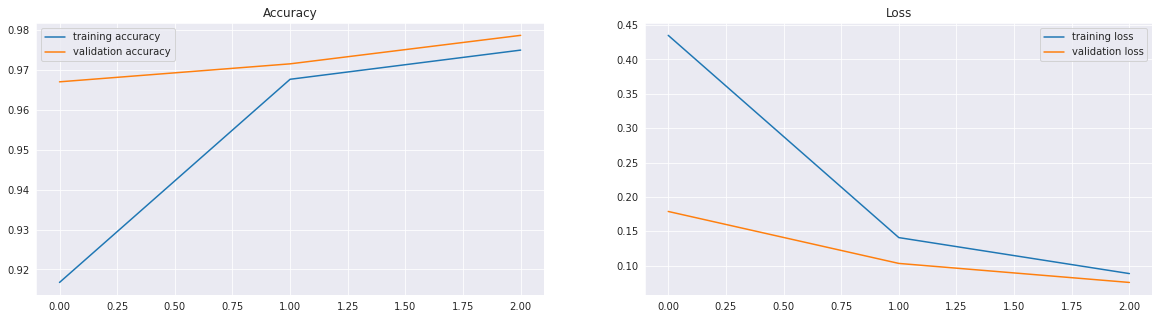

In [86]:
#Gráficos 
fig, ax = plt.subplots(figsize=(20, 5))

plt.subplot(1,2,1)
plt.title("Accuracy")
plt.plot(history2.history["acc"],label="training accuracy")
plt.plot(history2.history["val_acc"],label="validation accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.title("Loss")
plt.plot(history2.history["loss"],label="training loss")
plt.plot(history2.history["val_loss"],label="validation loss")
plt.legend()

plt.show()

In [87]:
y_pred2 = m2.predict(x_val)
y_pred2 = np.argmax(y_pred2, axis=1)
y2 = np.argmax(y_val, axis=1)
report2 = flat_classification_report(y2,y_pred2,labels=[0]+list(tag_to_code.values()), digits=4)
print(report2)

              precision    recall  f1-score   support

           0     0.9937    0.4313    0.6016    128682
           1     0.0414    0.1619    0.0660      3738
           2     0.0650    0.2004    0.0982      1881
           3     0.0980    0.3558    0.1537      1172
           4     0.1406    0.4204    0.2108      1282
           5     0.1414    0.4779    0.2182      1088
           6     0.1452    0.4937    0.2244      1039
           7     0.1458    0.5167    0.2274      1051
           8     0.1470    0.5109    0.2283       965
           9     0.1366    0.4890    0.2135      1002
          10     0.1406    0.4774    0.2172      1016
          11     0.1359    0.4782    0.2116       895
          12     0.1371    0.4314    0.2080       911
          13     0.1242    0.4058    0.1902       823
          14     0.1121    0.3794    0.1731       804
          15     0.1291    0.4109    0.1965       735
          16     0.1098    0.3504    0.1671       742
          17     0.1170    

**Respuesta**

Al duplicar el `embedding_dim` vemos una leve mejora en la precisión del modelo, pero esta mejora es muy pequeña realmente.

## 2.e) RNN Bidireccional y masking


##### I) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en 2.d.I) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.

In [88]:
from keras.layers import Bidirectional

In [89]:
options = ['sum', 'mul', 'concat', 'ave']

In [92]:
# Suma
model1 = Sequential()
model1.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=maxlen))
layer_lstm1 = LSTM(units=100,return_sequences=True)
model1.add(Bidirectional(layer_lstm1,merge_mode=options[0]))
model1.add(Dense(n_tags+1, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history1 = model1.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 137s 648ms/step - loss: 0.7041 - acc: 0.8777 - val_loss: 0.1314 - val_acc: 0.9678
Epoch 2/3
207/207 [==============================] - 133s 644ms/step - loss: 0.1118 - acc: 0.9696 - val_loss: 0.0810 - val_acc: 0.9759
Epoch 3/3
207/207 [==============================] - 133s 641ms/step - loss: 0.0730 - acc: 0.9791 - val_loss: 0.0548 - val_acc: 0.9855


In [93]:
model1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 140, 64)           1295680   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 140, 100)          132000    
_________________________________________________________________
dense_11 (Dense)             (None, 140, 18)           1818      
Total params: 1,429,498
Trainable params: 1,429,498
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Multiplicación
model2 = Sequential()
model2.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=maxlen))
layer_lstm2 = LSTM(units=100,return_sequences=True)
model2.add(Bidirectional(layer_lstm2,merge_mode=options[1]))
model2.add(Dense(n_tags+1, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history2 = model2.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 139s 657ms/step - loss: 1.1095 - acc: 0.8386 - val_loss: 0.1941 - val_acc: 0.9674
Epoch 2/3
207/207 [==============================] - 134s 648ms/step - loss: 0.1818 - acc: 0.9673 - val_loss: 0.1313 - val_acc: 0.9677
Epoch 3/3
207/207 [==============================] - 134s 649ms/step - loss: 0.1153 - acc: 0.9690 - val_loss: 0.0842 - val_acc: 0.9769


In [95]:
model2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 140, 64)           1295680   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 140, 100)          132000    
_________________________________________________________________
dense_12 (Dense)             (None, 140, 18)           1818      
Total params: 1,429,498
Trainable params: 1,429,498
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Concatenación
model3 = Sequential()
model3.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=maxlen))
layer_lstm3 = LSTM(units=100,return_sequences=True)
model3.add(Bidirectional(layer_lstm3,merge_mode=options[2]))
model3.add(Dense(n_tags+1, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history3 = model3.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 140s 664ms/step - loss: 0.7551 - acc: 0.8706 - val_loss: 0.1566 - val_acc: 0.9674
Epoch 2/3
207/207 [==============================] - 136s 659ms/step - loss: 0.1373 - acc: 0.9679 - val_loss: 0.0831 - val_acc: 0.9757
Epoch 3/3
207/207 [==============================] - 136s 657ms/step - loss: 0.0737 - acc: 0.9785 - val_loss: 0.0530 - val_acc: 0.9858


In [97]:
model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 140, 64)           1295680   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 140, 200)          132000    
_________________________________________________________________
dense_13 (Dense)             (None, 140, 18)           3618      
Total params: 1,431,298
Trainable params: 1,431,298
Non-trainable params: 0
_________________________________________________________________


In [98]:
# Promedio
model4 = Sequential()
model4.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=maxlen))
layer_lstm4 = LSTM(units=100,return_sequences=True)
model4.add(Bidirectional(layer_lstm4,merge_mode=options[3]))
model4.add(Dense(n_tags+1, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history4 = model4.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 138s 651ms/step - loss: 0.8910 - acc: 0.8372 - val_loss: 0.1732 - val_acc: 0.9672
Epoch 2/3
207/207 [==============================] - 134s 645ms/step - loss: 0.1710 - acc: 0.9670 - val_loss: 0.1532 - val_acc: 0.9678
Epoch 3/3
207/207 [==============================] - 133s 644ms/step - loss: 0.1383 - acc: 0.9677 - val_loss: 0.0925 - val_acc: 0.9736


In [99]:
model4.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 140, 64)           1295680   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 140, 100)          132000    
_________________________________________________________________
dense_14 (Dense)             (None, 140, 18)           1818      
Total params: 1,429,498
Trainable params: 1,429,498
Non-trainable params: 0
_________________________________________________________________


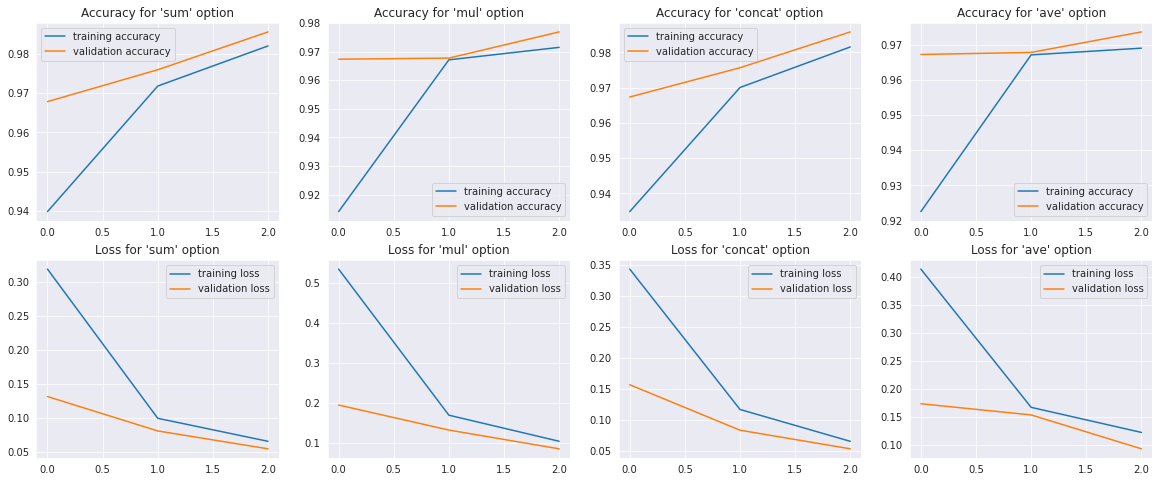

In [100]:
# Graficamos resultados
fig, ax = plt.subplots(figsize=(20, 8), sharex=True, sharey=True)

plt.subplot(2,4,1)
plt.title("Accuracy for 'sum' option")
plt.plot(history1.history["acc"],label="training accuracy")
plt.plot(history1.history["val_acc"],label="validation accuracy")
plt.legend()

plt.subplot(2,4,5)
plt.title("Loss for 'sum' option")
plt.plot(history1.history["loss"],label="training loss")
plt.plot(history1.history["val_loss"],label="validation loss")
plt.legend()

plt.subplot(2,4,2)
plt.title("Accuracy for 'mul' option")
plt.plot(history2.history["acc"],label="training accuracy")
plt.plot(history2.history["val_acc"],label="validation accuracy")
plt.legend()

plt.subplot(2,4,6)
plt.title("Loss for 'mul' option")
plt.plot(history2.history["loss"],label="training loss")
plt.plot(history2.history["val_loss"],label="validation loss")
plt.legend()

plt.subplot(2,4,3)
plt.title("Accuracy for 'concat' option")
plt.plot(history3.history["acc"],label="training accuracy")
plt.plot(history3.history["val_acc"],label="validation accuracy")
plt.legend()

plt.subplot(2,4,7)
plt.title("Loss for 'concat' option")
plt.plot(history3.history["loss"],label="training loss")
plt.plot(history3.history["val_loss"],label="validation loss")
plt.legend()

plt.subplot(2,4,4)
plt.title("Accuracy for 'ave' option")
plt.plot(history4.history["acc"],label="training accuracy")
plt.plot(history4.history["val_acc"],label="validation accuracy")
plt.legend()

plt.subplot(2,4,8)
plt.title("Loss for 'ave' option")
plt.plot(history4.history["loss"],label="training loss")
plt.plot(history4.history["val_loss"],label="validation loss")
plt.legend()

plt.show()

**Comentarios**

Entendiendo que los 4 `merge_mod`e que tenemos son:

- `sum`: que suma las salidas
- `mul`: que multiplica las salidas
- `concat`: las salidas se van concatenando, aumentan x2 la salida
- `ave`: saca el promedio de las salidas

Lo lógico sería pensar que para poder mantener el valor '0' que hemos utilizado en los padding, una manera de conservarlos sería el multiplicar las salidas.

En cuanto a los desempeños en los 4 modos

## 2.f) Mejora libre

En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras. Utilice la red entrenada, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.

In [101]:
from keras.layers import GRU

In [104]:
model_ = Sequential()
model_.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_dim, input_length=maxlen))
layer_lstm_ = LSTM(units=100,return_sequences=True)
model_.add(Bidirectional(layer_lstm2,merge_mode=options[1]))
model_.add(Dense(n_tags+1, activation='softmax'))
model_.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history_ = model_.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

ValueError: ignored

In [ ]:
model_.summary()

## 2.g) Escribamos palabras

##### I) Ahora buscaremos otra aplicación a las redes recurrentes, predecir el caracter siguiente. Si logramos entrenar una red que sea buena en esta tarea, podremos escribir texto automáticamente, pues podemos, a partir de una frase, predecir el caracter siguiente, y luego introducir la nueva frase sin el primer caracter en la red nuevamente, e iterando así escribir automáticamente. Si bien las redes recurrentes son adecuadas para esta tarea, no pretendemos entrenar un Shakespeare en esta tarea, sin embargo es interesante investigar qué tan verosimil o no puede lograr ser el texto generado.

Para esto, primero crearmos nuestro nuevo dataset. Para esta tarea preferiremos unir todas las frases en un solo gran corpus y luego crear nuevas secuencias semi redundantes. Esto nos evita primero el problema de tener que hacer padding, pues crearemos todas las entradas iguales, pero también nos permite aprovechar mejor el dataset, de cierta forma aumentando el número de datos. El target en este caso será solo el caracter siguiente correspondiente a cada secuencia.

En este item debe cargar el dataset. **Explique lo que hace el código entregado**

In [105]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical

In [106]:
# Carga en un dataframe el archivo ner.csv. El cual contiene información sobre la palabara, y la palabra previa y posterior
df_w = pd.read_csv(os.path.join("ner.csv"), engine='python', error_bad_lines=False)

# Obtenemos solo la columna 'word' y la asignamos al dataframe
df_w = df_w.dropna()[['word']]

# Une todas estas palabras en un string y pasa todo a minúsculas
corpus = ' '.join(list(df_w.word.values)).lower()

# Seteamos valores a utilizar
sentence_length = 40
steps = 5

# Inicializamos listas vacias
sentences = []
next_char = []

# Vamos a recorrer toda la variable corpus de 5 en 5 
for i in range(0,len(corpus) - sentence_length - 1 , steps):
  # Añadimos una sentencia de largo 40, en cada iteración, nos corremos 5 a la derecha
  sentences.append(corpus[i:sentence_length+i])
  # Añadimos la letra que viene luego de la sentencia previamente agregada
  next_char.append(corpus[sentence_length+i])

# Transformamos cada letra a un valor numérico {key:value}>{char:number}
chars_to_code = {char:code for code, char in enumerate(set(corpus))}

# Diccionario inverso al anterior {key:value}->{number:char}
code_to_chars = {code:char for char,code in chars_to_code.items()}

# Creamos un array que contiene cada una de las sentencias, con sus respectivos caracteres en valor numérico
x = np.array([[chars_to_code[char] for char in sentence] for sentence in sentences])

# Creamos un array que contiene cada uno de los caracteres que vienen luego de la sentencia, en valor numérico
y = np.array([chars_to_code[char] for char in next_char])

# Convierte el array en una matriz de clase binaria
y = to_categorical(y)

Skipping line 281837: Expected 25 fields in line 281837, saw 34


##### II) Entrene ahora una red con estos datos utilizando GRU. El resto de la estructura queda a su elección. Evalúe el desempeño de su red evaluando qué tan bien genera texto, puede utilizar las funciones propuestas como callback para ver como progresa su red. Pruebe a lo menos 2 estructuras distintas.

Una vez esté satisfecho de su red, hágala escribir algunos textos a partir de textos semilla elegidos por usted. Describa sus observaciones. ¿Qué cree ocurriría si entrenamos la red con otro dataset?

In [107]:
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LambdaCallback
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import sys

def predict_char(model, sentence):
    x = [chars_to_code[char] for char in sentence]
    x = pad_sequences([x], maxlen=sentence_length, padding='pre', value=0)
    probas = model.predict(x)[0]
    next_index = np.random.choice(len(chars_to_code), p=probas)
    return code_to_chars[next_index]

def on_epoch_end(epoch, logs):
    print(f'\n Generating random text for epoch: {epoch}')
    start_index = random.randint(0,x.shape[0]-1)
    sentence = ''.join([code_to_chars[code] for code in x[start_index]])
    print('\n Generating with seed: ' + sentence)
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_char(character, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

def on_epoch_try(character, epoch, log):
  print(f'\n Generating random text for epoch: {epoch}')
  print('\n Generating with seed: ' + log)
  sys.stdout.write(log)
  for i in range(400):
    next_char = predict_char(character, log)
    log = log[1:] + next_char #for next character
    sys.stdout.write(next_char)
    sys.stdout.flush()
    return

print_text_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [108]:
# ESTRUCTURA 1
character = Sequential()
embedding_dim = 100
character.add(Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1]))
character.add(GRU(128,return_sequences=False))
character.add(Dense(y.shape[1],activation='softmax'))
optimizer = RMSprop(lr = 0.01)
character.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["acc"])

In [109]:
history = character.fit(x,y, epochs=1, batch_size = 512,callbacks=[print_text_callback])

2371/2371 [==============================] - 733s 309ms/step - loss: 1.8494 - acc: 0.4581

 Generating random text for epoch: 0

 Generating with seed:  on wednesday , a car bomb blast in the 
 on wednesday , a car bomb blast in the asnan-process current by bordnely announcine 10,000 month . berior foromvers borghtons began countani war kazeemitionses by bondent in ameror for issurned borders of anromp fa a relany blamed trowk commedts an oppoinating bured protected sunday fournandran botes mijormatistangy neress internitucation boust killed eight whill aforcess more bo beyonding . " furler includand oppenes food process four

In [110]:
character.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 40, 100)           6000      
_________________________________________________________________
gru_8 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dense_16 (Dense)             (None, 60)                7740      
Total params: 102,060
Trainable params: 102,060
Non-trainable params: 0
_________________________________________________________________


Vamos a probar si el modelo puede predecir el caracter que viene a continuación de una sentencia dada. Tomaremos como ejemplo el siguiente párrafo:

`What were they eating? It didn't taste like anything she had ever eaten before and although she was famished, she didn't dare ask. She knew the answer would be one she didn't want to hear.`

En donde utilizaremos` what were they eating?` para realizar la predicción. Esperamos que el modelo nos entregue una `i`. Veamos.

In [111]:
predict_char(character, "what were they eating? ")

'd'

Veamos con la frase `she knew the answer wo`, y veamos si es capaz de predecir la `u` que sigue:

In [112]:
predict_char(character, "she knew the answer wo")

'u'

Evaluaremos ahora de que manera nuestro modelo puede ser capaz generar párrafos. Probaremos como lo hace para los primeros epochs, como para los últimos.

In [113]:
on_epoch_end(1,"")


 Generating random text for epoch: 1

 Generating with seed: kandahar province . the military says ne
kandahar province . the military says nerrogeul freselge after it " mound both fulled bothin abusened beapas and bronuce is in alano is looresdeyda been annucians and pait was been afrested bronse is been in pesseaking and manimzaus brities afreclates bashnwayerure been sandions in 1997gh for ecamiley polied laur . last movino ploying $ 2 and soir monena ) browers aran birdly considen bomb toad has blayed overessember bank illecanists a

Párrafo obtenido:

`kandahar province . the military says nerrogeul freselge after it " mound both fulled bothin abusened beapas and bronuce is in alano is looresdeyda been annucians and pait was been afrested bronse is been in pesseaking and manimzaus brities afreclates bashnwayerure been sandions in 1997gh for ecamiley polied laur . last movino ploying $ 2 and soir monena ) browers aran birdly considen bomb toad has blayed overessember bank illecanists a`

Un texto un tanto raro y pertubador. Veamos como nos va ahora ...


In [114]:
on_epoch_end(2300, "")


 Generating random text for epoch: 2300

 Generating with seed: e months ago , has demanded the release 
e months ago , has demanded the release been 's rulation in deadly behan 's approvesse borgo fulled into be polity connures in bronninghe ansta compledicatorians bothbred , acronst issues cramely both more budgan quna in eshermins in 2000 part be britising and for berishly prom-spokessminati promeded u.s. including communry brijed militrality quand-in sandon borman 's been government condity a been from proditudes serity resumu is in  a

Párrafo obtenido:

` e months ago , has demanded the release been 's rulation in deadly behan 's approvesse borgo fulled into be polity connures in bronninghe ansta compledicatorians bothbred , acronst issues cramely both more budgan quna in eshermins in 2000 part be britising and for berishly prom-spokessminati promeded u.s. including communry brijed militrality quand-in sandon borman 's been government condity a been from proditudes serity resumu is in  a`

In [115]:
# ESTRUCTURA 2
character2 = Sequential()
embedding_dim = 100
character2.add(Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1]))
character2.add(GRU(128,return_sequences=True))
character2.add(GRU(128,return_sequences=False))
character2.add(Dense(y.shape[1],activation='relu'))
optimizer2 = RMSprop(lr = 0.01)
character2.compile(loss='categorical_crossentropy', optimizer=optimizer2,metrics=["acc"])

In [116]:
character.fit(x,y, epochs=1, batch_size = 512,callbacks=[print_text_callback])

2371/2371 [==============================] - 744s 314ms/step - loss: 1.6831 - acc: 0.5018

 Generating random text for epoch: 0

 Generating with seed: are more effective against aids than ant
are more effective against aids than anttiverds heavily ralitriprenustersahin-ands exporot devinemandur . irary insesdavonters . sainito no selites sulah develtent esecleist , st thwadel paketual sebinits stated havk . andefu.sends . bune ese- prove betay se hegners exponseast nearroud prevered and afired insuaninted serideson beindeented . paolt sevelne invezued ahmergahred . says hoventy . sopocesealesse officialings says maril , eupl

In [117]:
character.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 40, 100)           6000      
_________________________________________________________________
gru_8 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dense_16 (Dense)             (None, 60)                7740      
Total params: 102,060
Trainable params: 102,060
Non-trainable params: 0
_________________________________________________________________


In [150]:
predict_char(character, "what were they eating? ")

'.'

Una interesante decisión.

**Utilización del Dataset**

Podemos ver como en ambos modelos el predictor tiende a escribir textos con temáticas de guerra, muertes, etc. Probablemnente esto se deba a que corpus se basa en noiticias. Si utilizaramos otro dataset, quizás uno de novelas románticas por ejemplo, tendríamos sentencias que hablaran más de amor y ese tipo de cosas.


**Comparación entre ambas arquitecturas**

Al agregar otra capa de GRU vemos que la precisión del modelo mejoró. Dado que toma mucho tiempo entrenar estas redes no se probó agregando más capas o probando más epoch.

